In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
PATH = "datasets/Kaggle_HPA_2018/"
data_path = Path(PATH)

In [4]:
NUM_CLASSES = 27
bs = 64
sz = [4,224,224]

In [5]:
# setting up a list of a random 20% of images in train as the validation set

lbl_csv = PATH + 'HPA_labels.csv'
n = len(list(open(lbl_csv))) -1
val_idxs = get_cv_idxs(n)

In [65]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.CENTER)
    data = ImageClassifierData.from_csv(PATH, 'train_all', lbl_csv, val_idxs = val_idxs, test_name='test_all', tfms=tfms, bs=bs, suffix = '.tiff', 
                                        balance=False)
    
    return data

In [66]:
# define augmentations
augs = [RandomDihedral()]

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs)

(31071, 28)


In [ ]:
data.test_dl.dataset.__dict__.keys()

### inpsect data_loaders

In [ ]:
x_test, y_test = next(iter(data.test_dl))

In [13]:
x, y = next(iter(data.trn_dl))

In [ ]:
# LEON, run cells below to load a bunch of batches and analyze their composition:

# 0) Initialize get_data with balance=True or False
# 1) run load_epoch() ... note the loop is right now limited to only 10 batches. Uncomment previous line to load all batches.
# 2) run 
#
#

In [8]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


In [9]:
xs, ys = load_epoch()

(array([19.,  4.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([  0. ,  29.2,  58.4,  87.6, 116.8, 146. , 175.2, 204.4, 233.6, 262.8, 292. ]),
 <a list of 10 Patch objects>)

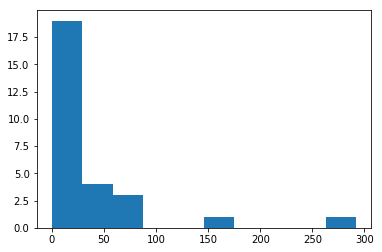

In [17]:
# analyze results
lbl_dist = ys.sum(axis=0)
plt.hist(lbl_dist)

In [ ]:
# this is what I ran with balance=True 

In [10]:
xs_balance, ys_balance = load_epoch()

(array([17.,  6.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([  0. ,  27.7,  55.4,  83.1, 110.8, 138.5, 166.2, 193.9, 221.6, 249.3, 277. ]),
 <a list of 10 Patch objects>)

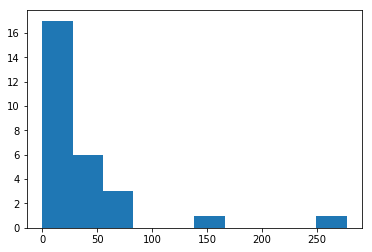

In [11]:
balance_lbl_dist = ys_balance.sum(axis=0)
plt.hist(balance_lbl_dist)

In [ ]:
to_np(y).shape

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [23]:
1/len(data.classes)

0.03571428571428571

In [ ]:
ys = data.trn_ds.y
fnames = data.trn_ds.fnames

In [31]:
ys.sum(axis=0)

array([10279.,  1003.,    23.,   877.,   546.,   430.,   833.,    17.,   418.,   160.,   677.,  1209.,
        2924.,   138.,  3000.,   624.,  2396.,   257.,  6605.,   266.,    10.,  1250.,  1463.,  1991.,
         819.,  2284.,    38.,    33.], dtype=float32)

In [63]:
ys = data.trn_ds.y

cut = 1/len(data.classes)
perc = (ys.sum(axis=0) / ys.sum())

weights_per_label = [cut / perc[i] for i in range(len(data.classes))]
weights_per_im = [np.max(ys[i] * weights_per_label) for i in range(len(ys))]

In [64]:
perc * weights_per_label

array([0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571,
       0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571,
       0.03571, 0.03571, 0.03571, 0.03571, 0.03571, 0.03571])

# training

In [ ]:
torch.cuda.is_available()

In [ ]:
# base-model

arch = resnet18_c
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

In [ ]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [ ]:
learn.unfreeze()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
# training loops:

In [ ]:
%time learn.fit(1e-2, 1, cycle_len=1, wds=wd, use_wd_sched=True)

In [ ]:
learn.save('first_model_1epoch')

In [ ]:
log_preds, y = learn.predict_with_targs()

## test-predictions

In [ ]:
log_preds, y =  learn.predict_with_targs('test')

In [ ]:
# creating submission file
thresh = 0.2



clss = np.arange(0, len(data.classes)) # get class indeces
res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > thresh)])) for p in log_preds]) # generating output

# ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
for i in range(res.shape[0]):
    if res[i] == '':
        res[i] = log_preds[i].argmax()

# getting image Ids
fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

# creating submission file
sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
sub_df.to_csv(f"{PATH}submissions/Test_submission_thresh_02.csv", index_label='Id')

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }